In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

pathToDataset = "../../Twitter-Absolute-Sigma-500.csv"
data = pandas.read_csv(pathToDataset, sep=",",encoding="utf8")


Retirer des données à étudier la dernière colonne correspondant au résultat (buzz ou pas buzz)

In [2]:
df_nonNormalized = data.iloc[:, :77]
print(df_nonNormalized.shape)
y = data.iloc[:,77]
df_nonNormalized.head()


(140707, 77)


,NCD_0,NCD_1,NCD_2,NCD_3,NCD_4,NCD_5,NCD_6,AI_0,AI_1,AI_2,...,ADL_4,ADL_5,ADL_6,NAD_0,NAD_1,NAD_2,NAD_3,NAD_4,NAD_5,NAD_6
0,889,939,960,805,805,1143,1121,549,613,587,...,1,1,1,889,939,960,805,805,1143,1121
1,542,473,504,626,647,795,832,366,288,318,...,1,1,1,542,473,504,626,647,795,832
2,92,99,196,100,184,79,162,66,59,118,...,1,1,1,92,99,196,100,184,79,162
3,90,87,92,344,184,848,184,83,78,76,...,1,1,1,90,87,92,344,184,848,184
4,169,98,101,90,96,95,185,141,68,85,...,1,1,1,169,98,101,90,96,95,185


In [9]:
column = df_nonNormalized
column[column==0] = 1
df_Normalized =(df_nonNormalized - df_nonNormalized.mean()) / column.std()

# Quelques exemples 

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline
def plotBuzz(data,n,withbuzz,withoutbuzz):
    notbuzzindex = np.where(y==0)[0][0:n]
    buzzindex = np.where(y==1)[0][0:n]

    nbColonnes = data.shape[1]
    buzz = data.iloc[buzzindex,:]
    notbuzz = data.iloc[notbuzzindex,:]
    
    nbVariables = int(round(nbColonnes / 7))
    x= np.tile(range(0,7),nbVariables)
    if withbuzz == 1 :
            plt.plot(x,buzz.transpose(),'-o', label = 'buzz')
    if  withoutbuzz == 1 :
           plt.plot(x,notbuzz.transpose(),'-^', label = 'no buzz')
    plt.legend()

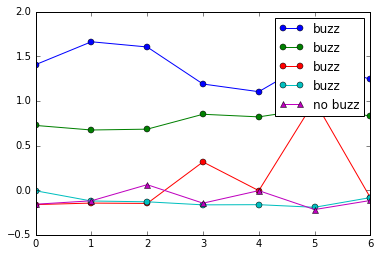

In [124]:
plotBuzz(df_Normalized.iloc[:,0:7],4,1,1)

# Réduction des variables 

In [6]:
indices_variables_auteurs = [7,49,56]

Ajout de nouvelles variables (colonnes) de l'accroissement entre t=0 et t=6 pour chacun des types des variables.

In [7]:
t = []
for i in range(0,76) : 
    ind = i %7
    if(ind == 0):
        t.append(i)

t = np.asarray(t)

In [35]:
accroissements = pandas.DataFrame({})
for i in t :
    maxes = df_nonNormalized.iloc[:,i:i+7].max(1)
#    maxes = df_nonNormalized.iloc[:,i+1:i+2].max(1)
    column = df_nonNormalized.iloc[:,i]
    # Pour les variables qui commencent a 0, eviter de diviser par 0
    column[column==0] = 1
    accroissements[i] = (maxes - df_nonNormalized.iloc[:,i])/column
accroissements.columns = df_nonNormalized.iloc[:,t].columns + "_increase"
#df_nonNormalized = pandas.concat([df_nonNormalized,accroissements],axis =1)

c:\users\wymeka\documents\python\python\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Méthode 1 : K-NN neighbours classifier

## Cross-validation testing (using 5 folds)

In [44]:
from sklearn.cross_validation import KFold
from sklearn import neighbors
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import mean_squared_error

def knnClassifier(data,y,n_jobs):
    scores = np.zeros((10,5))
    for n_neighbors in range(1,11):
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform",metric="manhattan",p=2,n_jobs=n_jobs)
#        scores[n_neighbors - 1] = cross_val_score(clf, data, y= y, cv=5,scoring="f1")
        y_predict = cross_val_predict(clf, data, y= y, cv=5)
        scores[n_neighbors - 1] = mean_squared_error( y_predict, y)**0.5
    mean_scores = scores.mean(1)
    k = mean_scores.argmax() +1
    print("K choisi : ",k," pour le score : ", mean_scores[k])

In [9]:
from sklearn.cross_validation import KFold
from sklearn import neighbors
from sklearn.cross_validation import train_test_split
clf = neighbors.KNeighborsClassifier(9, weights="uniform",metric="manhattan",p=2,n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(accroissements, y, test_size=0.8)
clf.fit(X_train,y_train)
y_predict = clf.predict(X_test)
mean_squared_error( y_predict, y_test)**0.5

0.43556837445258595

Classifier avec toutes les variables d'accroissements : 

In [32]:
import timeit
start_time = timeit.default_timer()
knnClassifier(accroissements,y,-1)
elapsed = timeit.default_timer() - start_time
print(elapsed,"seconds")

start_time = timeit.default_timer()
knnClassifier(accroissements,y,1)
elapsed = timeit.default_timer() - start_time
print(elapsed,"seconds")

K choisi :  9  pour le score :  0.807337239045
112.93011853763073 seconds
K choisi :  9  pour le score :  0.807337239045
216.96844549432262 seconds


Classifier qu'avec  les variables d'accroissement d'auteurs :

In [9]:
knnClassifier(accroissements.iloc[:,np.divide(indices_variables_auteurs,7)],y,-1)

TypeError: knnClassifier() missing 1 required positional argument: 'n_jobs'

Classifier qu'avec les variables liées aux discussions : 

In [23]:
indices_contributions_variables = np.setdiff1d(np.arange(0,11),np.divide(indices_variables_auteurs,7))
knnClassifier(accroissements.iloc[:,indices_contributions_variables],y,-1)

K choisi :  0  pour le score :  0.484994108692


# Méthode 2 : SVM 

# Random Forest pour sélection de variables 
On utilise le random forest sur toutes les variables à un seul instant (t=0) pour essayer de voir s'il y en a certaines qui se démarquent, en utilisant les importances de chacunes.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

t = []
for i in range(0,76) : 
    ind = i %7
    if(ind == 0):
        t.append(i)

t = np.asarray(t)
forest = RandomForestClassifier(n_estimators=5,
                              random_state=0)

forest.fit(df.iloc[:,t], y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
vraisIndices = t[indices]

([<matplotlib.axis.XTick at 0x7ad080>,
 <a list of 10 Text xticklabel objects>)

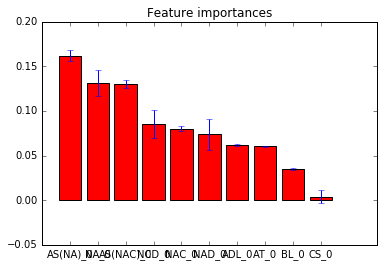

In [4]:
%matplotlib inline
plt.title("Feature importances")
plt.bar(range(1,len(t)), importances[indices][1:len(t)],
       color="r", yerr=std[indices[1:len(t)]], align="center")
plt.xticks(range(1,len(t)), df[vraisIndices[1:len(t)]].columns)

# Random forest sur toutes les variables

In [4]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=5,
                              random_state=0)

forest.fit(df, y)
importances = forest.feature_importances_
#std = np.std([tree.feature_importances_ for tree in forest.estimators_],
 #            axis=0)
indices = np.argsort(importances)[::-1]

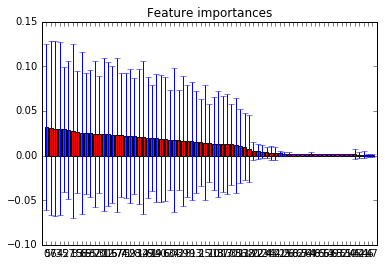

In [16]:
X = df

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

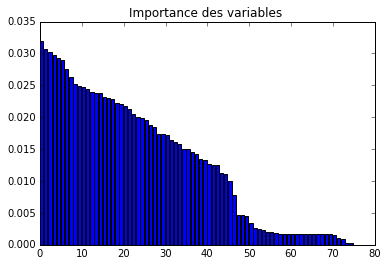

In [15]:
%matplotlib inline
plt.bar(range(X.shape[1]), importances[indices])
plt.title("Importance des variables ")

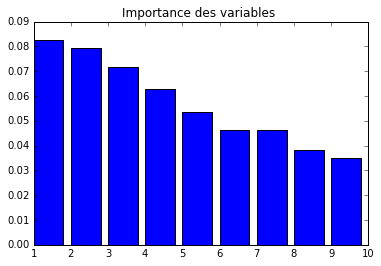

In [4]:
%matplotlib inline
plt.bar(range(1,10), importances[indices][1:10])
plt.title("Importance des variables ")

([<matplotlib.axis.XTick at 0x9cc3cf8>,
 <a list of 9 Text xticklabel objects>)

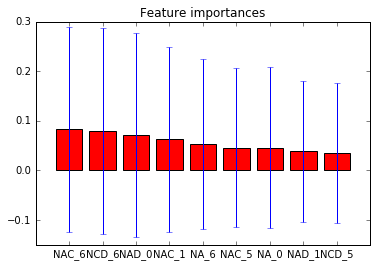

In [14]:
plt.title("Feature importances")
plt.bar(range(1,10), importances[indices][1:10],
       color="r", yerr=std[indices[1:10]], align="center")
plt.xticks(range(1,10), df[indices[1:10]].columns)

In [21]:
sum(importances[0:48])

0.67153481950719485

## Selection de features avec SelectModel

In [4]:
from sklearn.feature_selection import SelectFromModel
# threshold chosen is the mean (by default) (equivalent to importances[importances>np.mean(importances)])
model = SelectFromModel(forest, prefit=True)
X_new = model.transform(df)

In [8]:
test = pandas.DataFrame(X_new)
selectedVariables = df.columns[model.get_support(range(0,76))]

print("Les variables sélectionnées pour l'étude :",selectedVariables.tolist())


Les variables sélectionnées pour l'étude : ['NCD_6', 'AI_6', 'AS(NA)_6', 'BL_6', 'NAC_0', 'NAC_6', 'AS(NAC)_6', 'AT_6', 'NA_0', 'NA_6', 'ADL_6']
